# Review of classification techniques

## What we will accomplish

In this notebook we will:
- Review all of our classification techniques
- Apply them all to a new dataset
- Look at the decision boundaries when we train them on only 2 features
- Discuss the results

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# Wine dataset comes with sklearn
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

# Importing all of the classifiers we learned about
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

# Some of these need scaling first to work well 
# We will also see how polynomial features can give us nonlinear decision boundaries
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

# We will just use accuracy score for model comparison
from sklearn.metrics import accuracy_score


The following dataset comes from [Kaggle](https://www.kaggle.com/datasets/ehababoelnaga/diabetes-dataset/data).

In [2]:
df_train = pd.read_csv('../../data/diabetes_train.csv')
df_test = pd.read_csv('../../data/diabetes_test.csv')
X_train = df_train.iloc[:,:-1]
y_train = df_train.iloc[:,-1]
X_test = df_test.iloc[:,:-1]
y_test = df_test.iloc[:,-1]
X_train


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...,...
2455,3,126,88,41,235,39.3,0.704,27
2456,4,123,62,0,0,32.0,0.226,35
2457,1,80,74,11,60,30.0,0.527,22
2458,1,96,64,27,87,33.2,0.289,21


In [3]:
classifiers = {
    # Putting linear decision boundary classifiers first
    'lda' : LinearDiscriminantAnalysis(),
    'log_reg' : LogisticRegression(penalty=None, max_iter= 100000),
     'svc_linear' : LinearSVC(dual = 'auto'),

    # Quadratic boundaries
    'qda' : QuadraticDiscriminantAnalysis(),
    'lda_poly' : Pipeline([('scale', StandardScaler()),('poly',PolynomialFeatures(2)),('lda', LinearDiscriminantAnalysis())]),
    'log_reg_poly' : Pipeline([('scale', StandardScaler()),('poly',PolynomialFeatures(2)),('log_reg', LogisticRegression(penalty=None, max_iter= 100000))]),
    'gnb' : GaussianNB(),

    # Complex boundaries
    'knn' : Pipeline([('scale', StandardScaler()),('knn', KNeighborsClassifier())]),   
    'svc_rbf' : Pipeline([('scale', StandardScaler()),('svc',SVC(kernel= 'rbf'))])
}

In [4]:
for model_name, model in classifiers.items():
    model.fit(X_train,y_train)

accs = {model_name: accuracy_score(y_test, model.predict(X_test)) for model_name, model in classifiers.items()}

accs

{'lda': 0.801948051948052,
 'log_reg': 0.801948051948052,
 'svc_linear': 0.8084415584415584,
 'qda': 0.75,
 'lda_poly': 0.7857142857142857,
 'log_reg_poly': 0.7824675324675324,
 'gnb': 0.788961038961039,
 'knn': 0.711038961038961,
 'svc_rbf': 0.7987012987012987}

We now train the same models on only two features so we can visualize what is going on.

We use pairplot to select two features which appear to be discriminating.

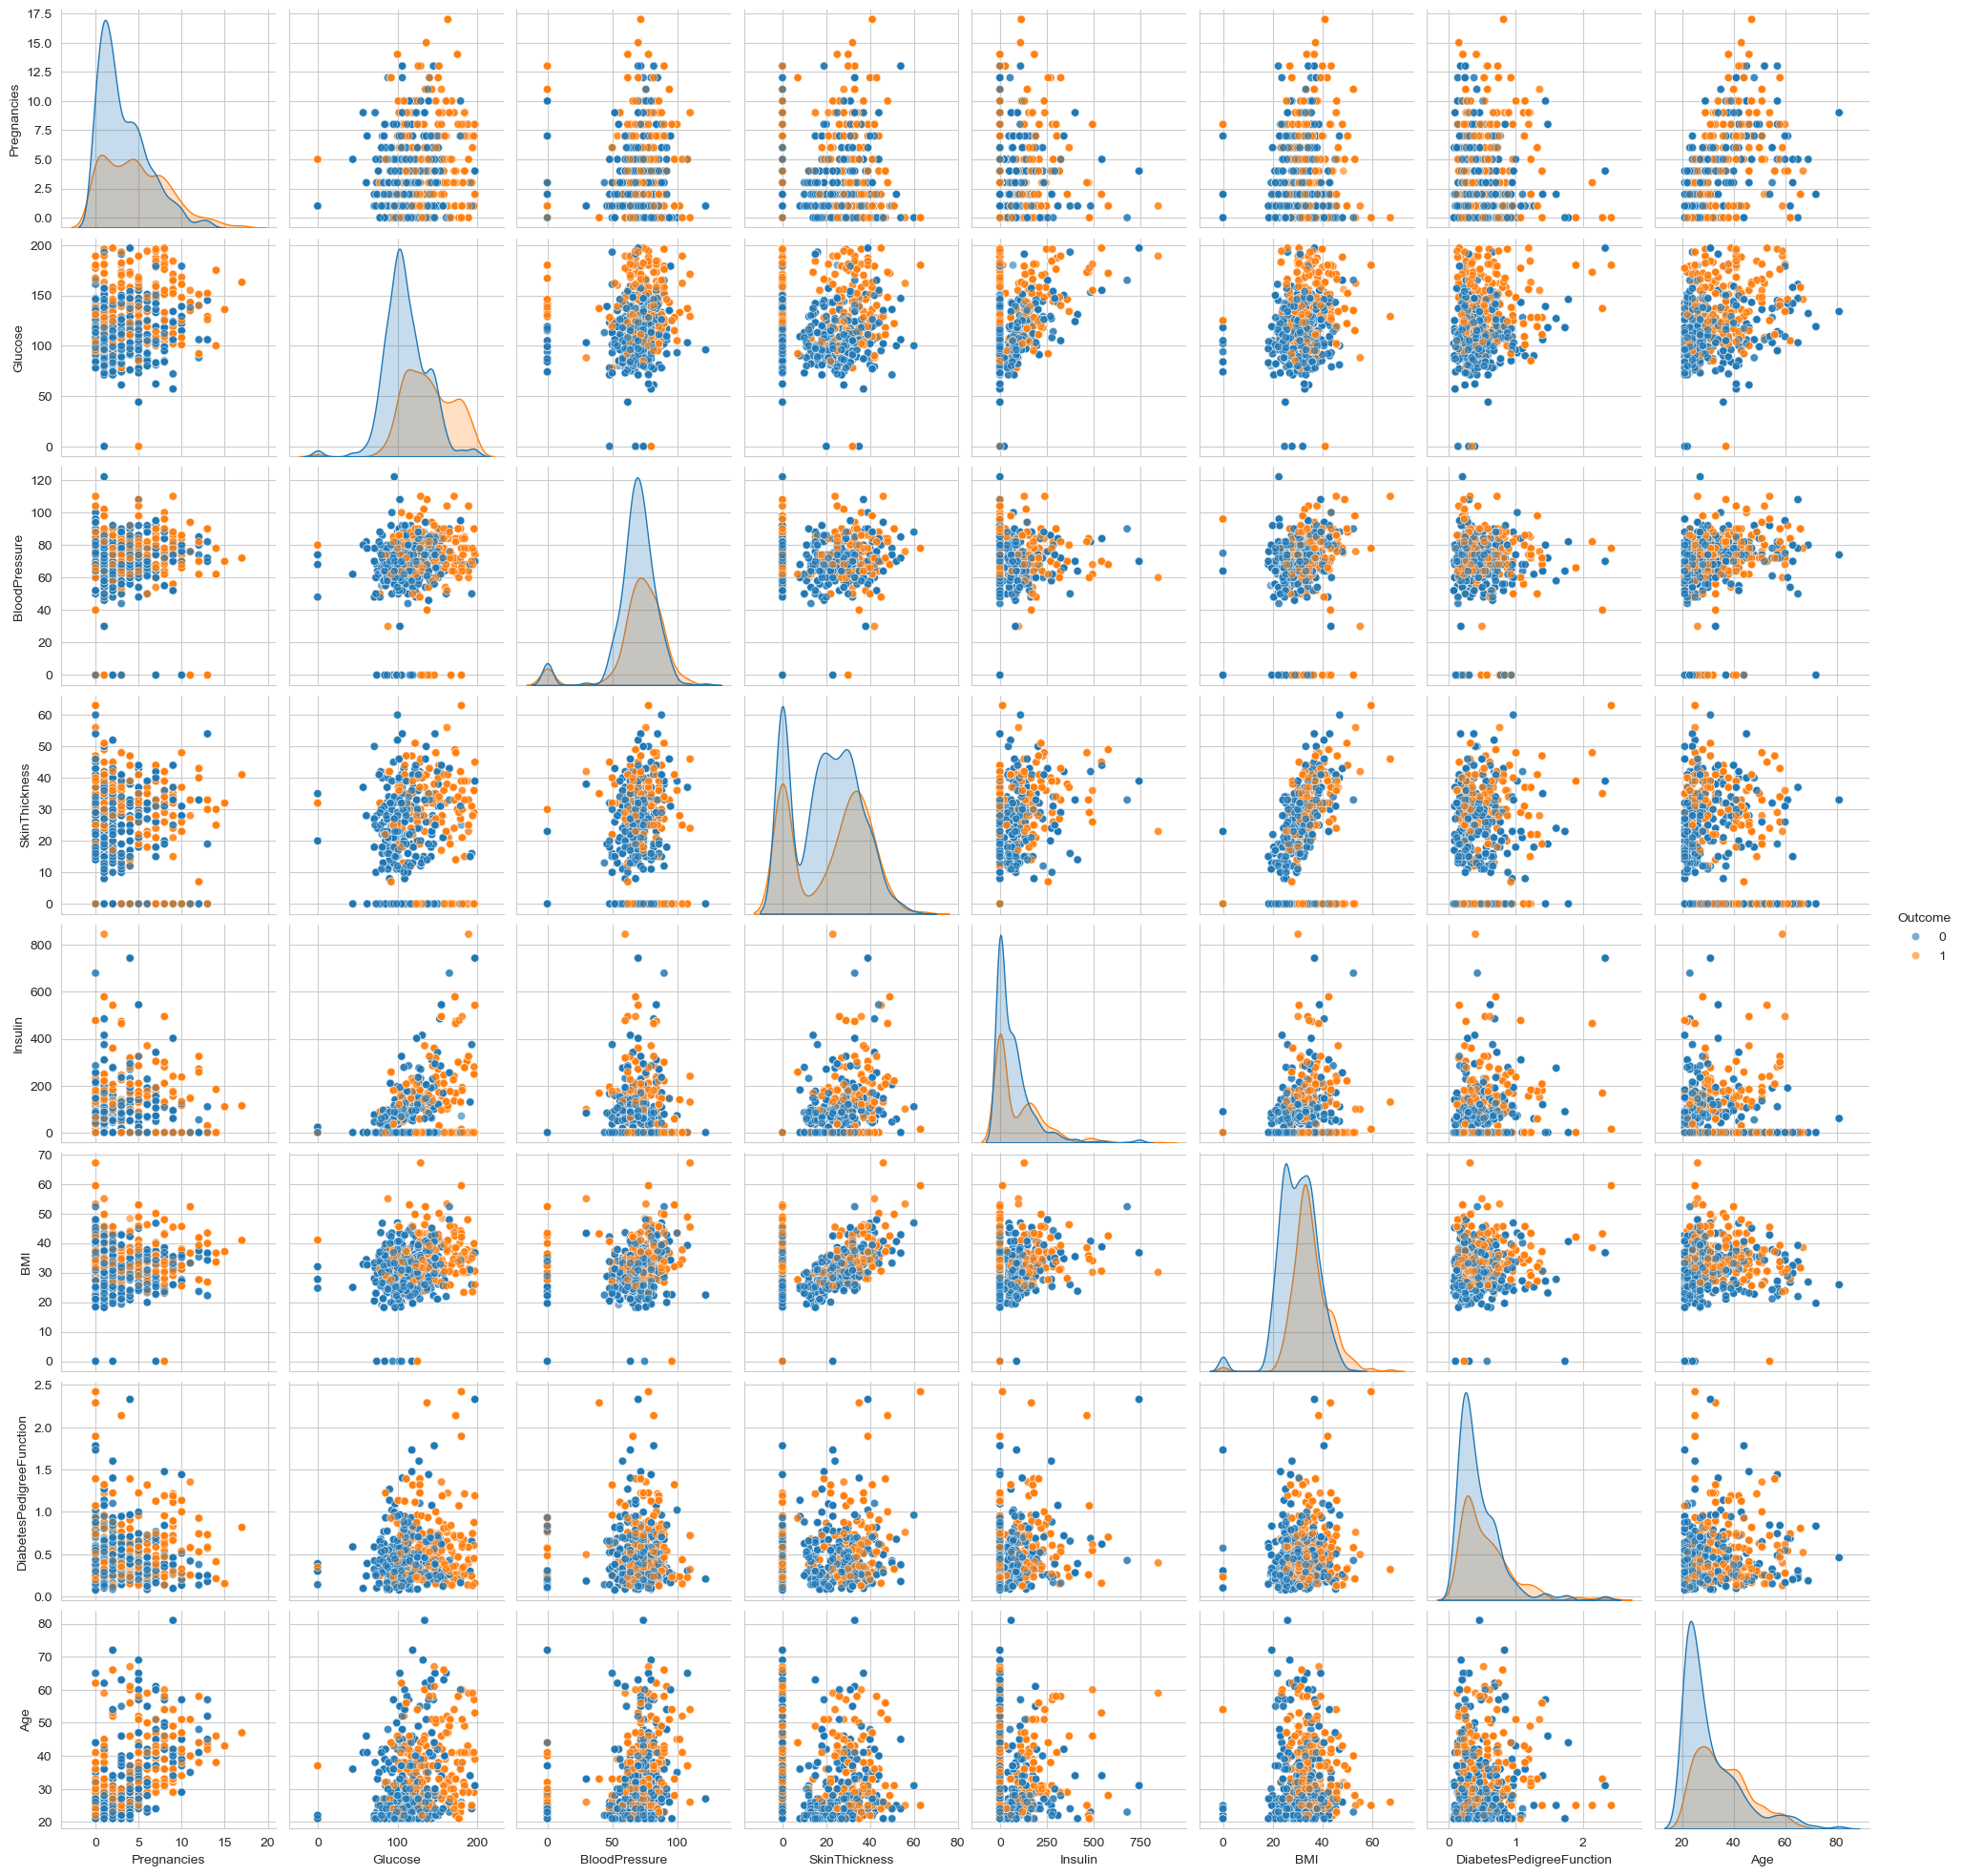

In [5]:
sns.pairplot(data = df_train,
                x_vars = df_train.columns[:-1],
                y_vars = df_train.columns[:-1],
                hue = df_train.columns[-1],
                plot_kws = {'alpha':.6})

plt.show()

`BMI` and `Glucose` appear to be fairly good at seperating the classes.  They also have the advantage of being easily measured at home.

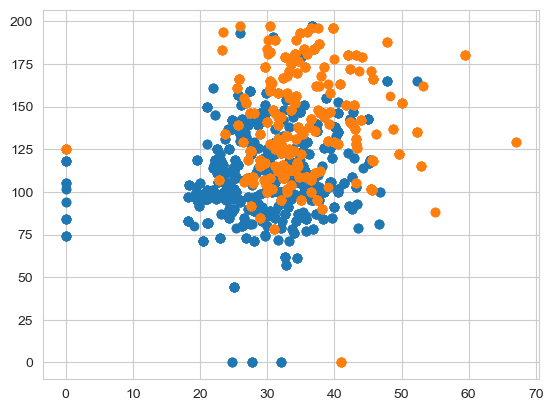

In [6]:
plt.scatter(X_train[y_train == 0]['BMI'], X_train[y_train == 0]["Glucose"])
plt.scatter(X_train[y_train == 1]['BMI'], X_train[y_train == 1]["Glucose"])

plt.show()

In [7]:
for model_name, model in classifiers.items():
    model.fit(X_train[['BMI','Glucose']],y_train)

test_accs = {model_name: accuracy_score(y_test, model.predict(X_test[['BMI','Glucose']])) for model_name, model in classifiers.items()}

test_accs

{'lda': 0.7954545454545454,
 'log_reg': 0.7954545454545454,
 'svc_linear': 0.7954545454545454,
 'qda': 0.7987012987012987,
 'lda_poly': 0.788961038961039,
 'log_reg_poly': 0.7824675324675324,
 'gnb': 0.7987012987012987,
 'knn': 0.6818181818181818,
 'svc_rbf': 0.775974025974026}

Interestingly, we get pretty similar model performance for most of these models using only these two features.  This is nice from an interpretability perspective.  The ones with linear decision boundaries will give us very simple decision rules.

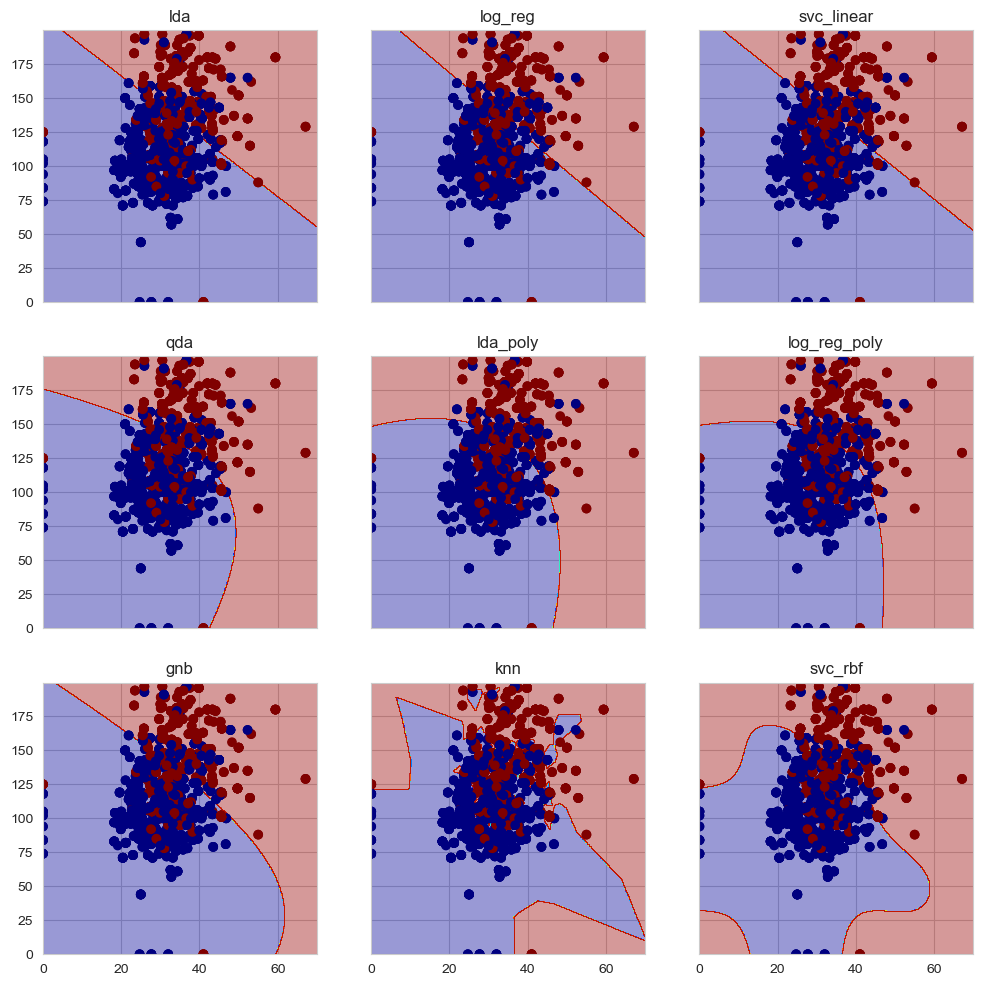

In [8]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12,12))

xx, yy = np.mgrid[0:70:.1, 0:200:.1]

grid = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns = ['BMI','Glucose'])

for i,(model_name,model) in enumerate(classifiers.items()):
    preds = model.predict(grid).reshape(xx.shape)
    indices = divmod(i, 3)
    contour = axs[indices].contourf(xx, yy, preds, 25, alpha = 0.4,
                      vmin=0, vmax=1, cmap=plt.cm.jet)

    axs[indices].scatter(X_train['BMI'], X_train['Glucose'], c = y_train, cmap=plt.cm.jet)
    axs[indices].title.set_text(model_name)

plt.show()

A few observations:

* All of the classifiers with linear decision boundaries (LDA, logistic regression, linear SVC) are giving us extremely similar decision boundaries.
* kNN and SVC with RBF kernel can have complex boundaries.  This is a plus if your data really is that complex, but it isn't helping us here.  kNN can be prone to overfitting.
    * The decision boundaries look similar.  This is not a coincidence!  SVC with RBF kernel can be thought of as a "smoother"  kNN.
* I showcased how transforming the features with nonlinear transformations can give us non-linear boundaries even using logistic regression and LDA.

We also give an example decision rule using our logistic regression model.

We have 

$$
P(y = 1 | (\textrm{BMI} = x_0, \textrm{Glocose} = x_1)) = \left( 1 + \exp(- (b_0 + b_{\textrm{bmi}} x_0 + b_{\textrm{glu}} x_1 )) \right)^{-1}
$$

So our decision rule is 

$$
\begin{align*}
P(y = 1 | (\textrm{BMI} = x_0, \textrm{Glocose} = x_1)) &\geq \frac{1}{2}\\
b_0 + b_{\textrm{bmi}} x_0 + b_{\textrm{glu}} x_1 &\geq 0\\
b_{\textrm{bmi}} x_0 + b_{\textrm{glu}} x_1  &\geq -b_0\\
\end{align*}
$$

In [9]:
b_bmi, b_glu = classifiers['log_reg'].coef_.reshape(2,)

b_0, = classifiers['log_reg'].intercept_

In [10]:
print(f'If ({b_bmi: .3f} BMI + {b_glu: .3f} Glucose ) is more than {-1*b_0:.2f} the logistic regression model gives you a 50% or greater chance of having diabetes.')

If ( 0.077 BMI +  0.032 Glucose ) is more than 6.90 the logistic regression model gives you a 50% or greater chance of having diabetes.


--------------------------

This notebook was written for the Erdős Institute Data Science Boot Camp by Steven Gubkin.

Please refer to the license in this repo for information on redistribution.